# Technology focus: SpaceM

SpaceM (<b>spa</b>tial single-<b>ce</b>ll <b>m</b>etabolomics) is a method for detecting metabolites on single cells, combined with a fluorescence-based readout and morpho-spatial features. It uses MALDI imaging mass spectrometry and microscopy before (pre-MALDI) and after (post-MALDI).

[Rappez, L., Stadler, M., Triana, S. et al. SpaceM reveals metabolic states of single cells. Nat Methods 18, 799–805 (2021).](https://doi.org/10.1038/s41592-021-01198-0)

This notebook illustrates how to visualize a SpaceM dataset, and how to extract and further analyze ion spectra (in a much simplified way).

In [1]:
import json

import numpy as np
import pandas as pd
import scanpy as sc
import spatialdata as sd
import spatialdata_plot  # noqa: F401

COORD_SYS_GLOBAL = "global"
INSTANCE_KEY = "instance_id"
YX = ("y", "x")

/opt/miniconda3/envs/ome311/lib/python3.11/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(


## Loading the data

Please download the data from here: [SpaceM dataset (small)](https://s3.embl.de/spatialdata/spatialdata-sandbox/spacem_helanih3t3.zip) and rename it (eventually using symlinks) to spacem_helanih3t3.zarr.

The dataset above is a subset of the original data that is used to reduce runtime. If you want to rerun the analysis using the full dataset please download the data from here instead [SpaceM dataset](https://s3.embl.de/spatialdata/raw_data/20221014_HeLaNIH3T3.zip).

In [2]:
spatialdata_path = "./spacem_helanih3t3.zarr"

In [3]:
spacem_sdata = sd.read_zarr(spatialdata_path)
adata = spacem_sdata.tables["table"]
spacem_sdata

/opt/miniconda3/envs/ome311/lib/python3.11/site-packages/zarr/creation.py:614: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)
/opt/miniconda3/envs/ome311/lib/python3.11/site-packages/zarr/creation.py:614: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)
/opt/miniconda3/envs/ome311/lib/python3.11/site-packages/zarr/creation.py:614: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)
/opt/miniconda3/envs/ome311/lib/python3.11/site-packages/zarr/creation.py:614: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)
/opt/miniconda3/envs/ome311/lib/python3.11/site-packages/zarr/creation.py:614: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, 

SpatialData object, with associated Zarr store: /Users/macbook/embl/projects/basel/spatialdata-sandbox/spacem_helanih3t3/data.zarr
├── Images
│     ├── 'Slide2.B2.post_maldi': DataTree[cyx] (2, 2675, 2675), (2, 1337, 1337), (2, 668, 668)
│     ├── 'Slide2.B2.pre_maldi': DataTree[cyx] (2, 2675, 2675), (2, 1337, 1337), (2, 668, 668)
│     ├── 'Slide2.H3.post_maldi': DataTree[cyx] (2, 2675, 2675), (2, 1337, 1337), (2, 668, 668)
│     └── 'Slide2.H3.pre_maldi': DataTree[cyx] (2, 2675, 2675), (2, 1337, 1337), (2, 668, 668)
├── Labels
│     ├── 'Slide2.B2.0.ablation_marks': DataTree[yx] (2675, 2675), (1337, 1337), (668, 668)
│     ├── 'Slide2.B2.0.cells': DataTree[yx] (1662, 1724), (831, 862), (415, 431)
│     ├── 'Slide2.H3.0.ablation_marks': DataTree[yx] (2675, 2675), (1337, 1337), (668, 668)
│     └── 'Slide2.H3.0.cells': DataTree[yx] (1659, 1720), (829, 860), (414, 430)
├── Points
│     └── 'Slide2.maldi_points': DataFrame with shape: (<Delayed>, 8) (2D points)
├── Shapes
│     ├── 'Slid

## Visualise the data

For high-throughput experiments, typically 40-well slides are used. Each well can (theoretically) contain more then one measured MALDI ion image. Therefore, all items are named with IDs. Here, we select one for visualization.

In [4]:
slide_id = "Slide2"
well_id = "B2"
maldi_region_id = 0

All SpatialData elements are named with unique (configurable) names.

The layout is a shapes layer with all wells of a slide as polygons. Similarly, the MALDI regions contain polygons for measure ion images.

In [5]:
ablation_marks_image_name = f"{slide_id}.{well_id}.post_maldi"
ablation_marks_labels_name = f"{slide_id}.{well_id}.{maldi_region_id}.ablation_marks"
cells_image_name = f"{slide_id}.{well_id}.pre_maldi"
cells_labels_name = f"{slide_id}.{well_id}.{maldi_region_id}.cells"
layout_name = f"{slide_id}.layout"
maldi_regions_name = f"{slide_id}.maldi_regions"
coord_sys_name = f"{slide_id}.{well_id}.{maldi_region_id}"

Get the well's bounding box as region of interest for plotting.

In [6]:
well_shapes_instance = (
    adata.obs.loc[(adata.obs.region == layout_name) & (adata.obs.slide_id == slide_id) & (adata.obs.well_id == well_id)]
    .iloc[0]
    .instance_id
)
well_polygon = spacem_sdata.shapes[layout_name].geometry.iloc[well_shapes_instance]
# Note that Shapely has XY order, but we use YX. Bounds: min_x, min_y, max_x, max_y
# Add some offset to visualize a bit more of the image
offset = 200
min_coordinate_yx = [well_polygon.bounds[1] - offset, well_polygon.bounds[0] - offset]
max_coordinate_yx = [well_polygon.bounds[3] + offset, well_polygon.bounds[2] + offset]

### Ablation marks

/tmp/ipykernel_51975/3413683486.py:12: DeprecationWarning: `elements` is being deprecated as an argument to `PlotAccessor.render_images.render_images` in spatialdata_plot version version 0.3.0, switch to `element` instead.
  sdata_cropped.pl.render_images(elements=ablation_marks_image_name, palette=["gray", "blue"])
/tmp/ipykernel_51975/3413683486.py:13: DeprecationWarning: `elements` is being deprecated as an argument to `PlotAccessor.render_labels.render_labels` in spatialdata_plot version 0.3.0, switch to `element` instead.
  .pl.render_labels(elements=ablation_marks_labels_name, color=INSTANCE_KEY, cmap="viridis", fill_alpha=1.0)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.035432525951557].


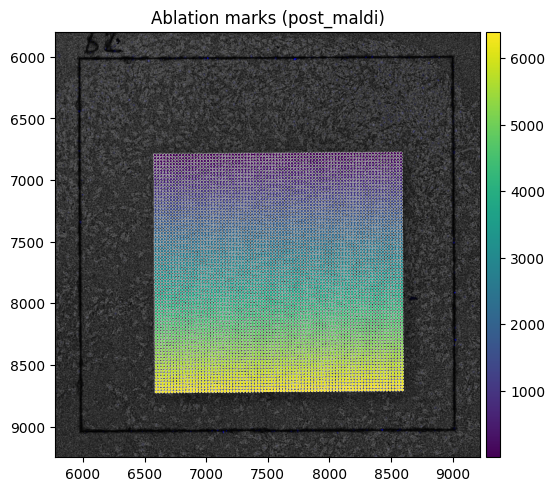

In [7]:
%matplotlib inline

# FIXME: wrong image region is plotted with bounding box query
# sdata_cropped = spacem_sdata.query.bounding_box(
#     axes=YX,
#     min_coordinate=min_coordinate_yx,
#     max_coordinate=max_coordinate_yx,
#     target_coordinate_system=COORD_SYS_GLOBAL,
# )
sdata_cropped = spacem_sdata
fig = (
    sdata_cropped.pl.render_images(elements=ablation_marks_image_name, palette=["gray", "blue"])
    .pl.render_labels(elements=ablation_marks_labels_name, color=INSTANCE_KEY, cmap="viridis", fill_alpha=1.0)
    # .pl.render_shapes(
    #    elements=maldi_regions_name, fill_alpha=0.0, outline=True, outline_color="mediumvioletred"
    # )
    .pl.show(
        coordinate_systems=COORD_SYS_GLOBAL,
        title="Ablation marks (post_maldi)",
        return_ax=True,
    )
    .figure
)
# In this example we set a continuous gradient to the integer label values.
# The colorbar formatter might have floats, change them to integers.
colorbar = fig.findobj(lambda obj: hasattr(obj, "colorbar") and obj.colorbar)[0].colorbar
colorbar.formatter = "{x:.0f}"
None

### Cells

/tmp/ipykernel_51975/2615245944.py:4: DeprecationWarning: `elements` is being deprecated as an argument to `PlotAccessor.render_images.render_images` in spatialdata_plot version version 0.3.0, switch to `element` instead.
  sdata_cropped.pl.render_images(elements=cells_image_name, palette=["gray", "lime"]).pl.render_labels(
/tmp/ipykernel_51975/2615245944.py:4: DeprecationWarning: `elements` is being deprecated as an argument to `PlotAccessor.render_labels.render_labels` in spatialdata_plot version 0.3.0, switch to `element` instead.
  sdata_cropped.pl.render_images(elements=cells_image_name, palette=["gray", "lime"]).pl.render_labels(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.5019607843137255].


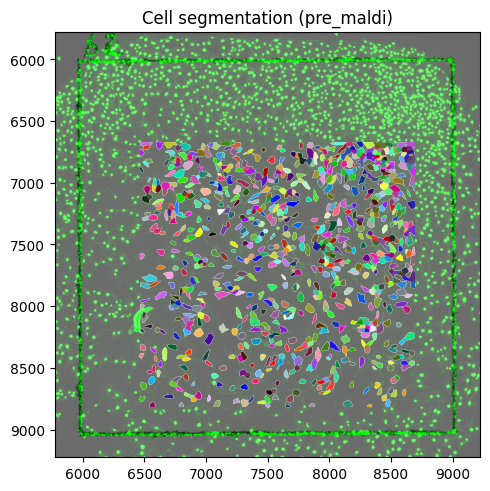

In [8]:
%matplotlib inline

(
    sdata_cropped.pl.render_images(elements=cells_image_name, palette=["gray", "lime"])
    .pl.render_labels(elements=cells_labels_name, fill_alpha=1.0)
    # .pl.render_shapes(elements=maldi_regions_name, fill_alpha=0.0, outline=True, outline_color="mediumvioletred")
    .pl.show(coordinate_systems=COORD_SYS_GLOBAL, title="Cell segmentation (pre_maldi)")
)
None

### Ions as measured with MALDI imaging mass spectrometry

During SpaceM data processing, ablation marks are segmented matched to ion images from METASPACE. For this, it is important that the segmented ablation marks are labeled in the same order as the corresponding pixels in the ion image. Ion images are three-dimensional and provide ion counts (or intensities) for dimensions (Y × X × detected ions).

The AnnData table's `X` matrix is a "flattened" ion image of dimensions (pixels × ions).

Names of detected ions are stored in `var_names`. Since this dataset is integrated from many METASPACE datasets, if ions are detected only in some of them but not in others, the `X` matrix may contain NaN. Ion formulas are ambiguous and can represent different metabolites, which need to be confirmed by detailed inspection on METASPACE or further targeted measurments. Names of possible candidates are stored in a `moleculeNames` column in the `var` dataframe.

Which metabolites are biologically meaningful depends on the biological question and pathways involved. Just for the purpose of visualization, ions with a good colocalization to cells are interesting. Such ions are typically fluorescein "C20H12O5-H" or any long lipids like "C18H34O2-H", C18.\*, C19.\*, if detected.

In [9]:
# Here, we automatically select the first non-zero ion with highest variance,
# but any other ion from var_names can be selected manually.
_adata_roi = adata[adata.obs.region == ablation_marks_labels_name]
selected_ion = _adata_roi.var_names[np.nanargmax(np.nanvar(_adata_roi.X, axis=0))]
selected_ion

'C5H9NO4-H'

/tmp/ipykernel_51975/3747362445.py:4: DeprecationWarning: `elements` is being deprecated as an argument to `PlotAccessor.render_images.render_images` in spatialdata_plot version version 0.3.0, switch to `element` instead.
  sdata_cropped.pl.render_images(elements=ablation_marks_image_name, palette=["gray", "lime"])
/tmp/ipykernel_51975/3747362445.py:5: DeprecationWarning: `elements` is being deprecated as an argument to `PlotAccessor.render_labels.render_labels` in spatialdata_plot version 0.3.0, switch to `element` instead.
  .pl.render_labels(elements=ablation_marks_labels_name, color=selected_ion, cmap="viridis", fill_alpha=1.0)
/Users/macbook/embl/projects/basel/spatialdata/src/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'Slide2.H3.0.ablation_marks', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)
/Users/macbook/embl/projects/basel/spatialdata/src/spatialdata/_core/spatialdata.py:185: UserWarning: The table is a

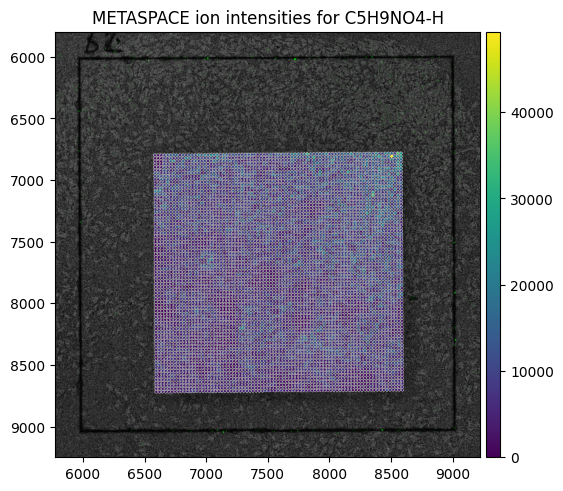

In [10]:
%matplotlib inline

(
    sdata_cropped.pl.render_images(elements=ablation_marks_image_name, palette=["gray", "lime"])
    .pl.render_labels(elements=ablation_marks_labels_name, color=selected_ion, cmap="viridis", fill_alpha=1.0)
    .pl.show(coordinate_systems=coord_sys_name, title=f"METASPACE ion intensities for {selected_ion}")
)
None

### Ions deconvolved to cells

Raw ion intensities from ion images are deconvolved and mapped to segmented cells by some advanced algorithms.
They are stored in the AnnData table's `X` matrix for cell labels.

In [11]:
# Here, we automatically select the first non-zero ion with highest variance,
# but any other ion from var_names can be selected manually.
_adata_roi = adata[adata.obs.region == cells_labels_name]
selected_ion = _adata_roi.var_names[np.nanargmax(np.nanvar(_adata_roi.X, axis=0))]
selected_ion

/tmp/ipykernel_51975/3149558297.py:4: RuntimeWarning: Degrees of freedom <= 0 for slice.
  selected_ion = _adata_roi.var_names[np.nanargmax(np.nanvar(_adata_roi.X, axis=0))]


'C5H9NO4-H'

/tmp/ipykernel_51975/830254196.py:7: DeprecationWarning: `elements` is being deprecated as an argument to `PlotAccessor.render_images.render_images` in spatialdata_plot version version 0.3.0, switch to `element` instead.
  sdata_cropped.pl.render_images(elements=cells_image_name, palette=["gray", "lime"])
/tmp/ipykernel_51975/830254196.py:8: DeprecationWarning: `elements` is being deprecated as an argument to `PlotAccessor.render_labels.render_labels` in spatialdata_plot version 0.3.0, switch to `element` instead.
  .pl.render_labels(elements=cells_labels_name, color=selected_ion, cmap="viridis", fill_alpha=1.0)
/Users/macbook/embl/projects/basel/spatialdata/src/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'Slide2.H3.0.ablation_marks', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)
/Users/macbook/embl/projects/basel/spatialdata/src/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'Slide2.H3

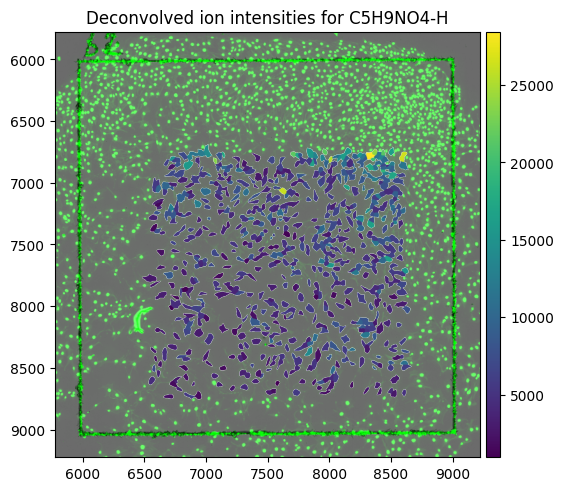

In [12]:
%matplotlib inline

# FIXME: Some labels have no ion values assigned (but NaN) since they are not overlapped by ablation marks.
# It seems spatialdata-plot does not apply na_color=(0.0, 0.0, 0.0, 0.0), but renders all (!) with random colors.
sdata_cropped.tables["table"].X = np.nan_to_num(sdata_cropped.tables["table"].X, nan=0)
(
    sdata_cropped.pl.render_images(elements=cells_image_name, palette=["gray", "lime"])
    .pl.render_labels(elements=cells_labels_name, color=selected_ion, cmap="viridis", fill_alpha=1.0)
    .pl.show(coordinate_systems=coord_sys_name, title=f"Deconvolved ion intensities for {selected_ion}")
)
None

## Analysis

Since we use a single table, it contains annotations of other SpatialData elements.
Select the AnnData for cells and ion detected for these cells (not NaN).

In [14]:
adata = spacem_sdata.tables["table"]
cells_adata = adata[adata.obs.object_type == "cells", :]
not_nan_ions = np.all(np.isfinite(cells_adata.X), axis=0)
cells_adata = cells_adata[:, not_nan_ions]
cells_adata.shape

(1583, 327)

Preprocessing recipe

In [15]:
# Drop cells that have not at least 5% or 5 ions detected.
sc.pp.filter_cells(cells_adata, min_genes=min(int(0.05 * cells_adata.n_vars), 5))
# Drop ions that have not been detected in at least 10% or 25 cells.
sc.pp.filter_genes(cells_adata, min_cells=min(int(0.1 * cells_adata.n_obs), 25))
sc.pp.normalize_total(cells_adata, target_sum=10e4)
# Metabolomics data always requires log transformation
sc.pp.log1p(cells_adata)
# We don't do scaling for metabolomics data.
# sc.pp.scale(cells_adata, zero_center=True)

/opt/miniconda3/envs/ome311/lib/python3.11/site-packages/scanpy/preprocessing/_simple.py:168: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["n_genes"] = number


UMAP before data integration

In [16]:
CONDITION_COL = "condition"

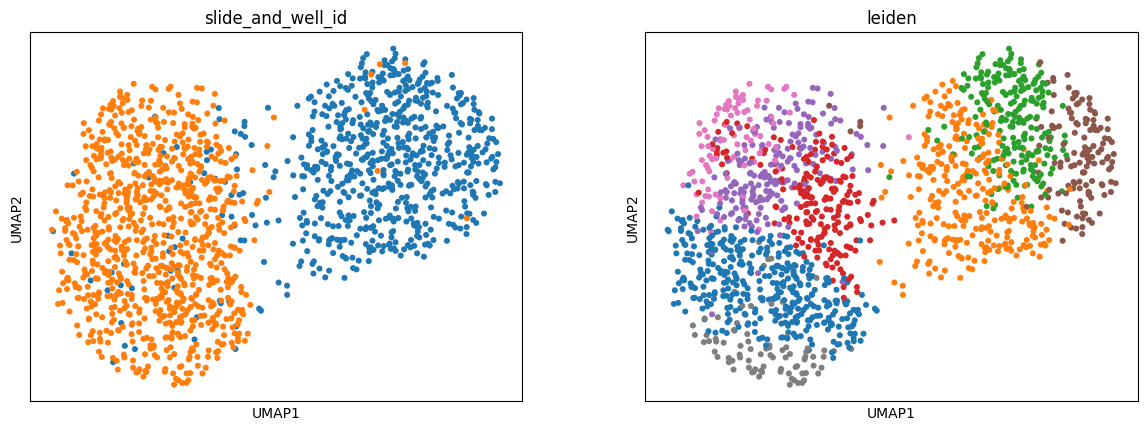

In [25]:
sc.pp.pca(cells_adata)
sc.pp.neighbors(cells_adata)
sc.tl.leiden(cells_adata)
sc.tl.umap(cells_adata)
cells_adata.obs["slide_and_well_id"] = cells_adata.obs.apply(lambda r: f"{r.slide_id}.{r.well_id}", axis=1)
sc.pl.umap(cells_adata, color=["slide_and_well_id", "leiden"], legend_loc=None)

## Differential analysis

With differential analysis, we can identify what metabolites make up the difference between clusters of cells.

We use a series of 1-vs-rest Wilcoxon rank-sum tests for each ion:

In [26]:
cells_adata.obs

,area_sampling,area_sampling_proportion,am_nearest_cell_distance,centroid-0,centroid-1,bbox-0,bbox-1,bbox-2,bbox-3,centroid_local-0,...,ny,dx,dy,layout_name,region,instance_id,replicate,condition,n_genes,slide_and_well_id
6400,NaN,NaN,NaN,119.817683,842.154867,26.0,798.0,192.0,901.0,93.817683,...,NaN,NaN,NaN,NaN,Slide2.B2.0.cells,21,19,NIH3T3,50,Slide2.B2
6401,NaN,NaN,NaN,119.348150,3152.362415,60.0,3114.0,171.0,3191.0,59.348150,...,NaN,NaN,NaN,NaN,Slide2.B2.0.cells,35,19,NIH3T3,75,Slide2.B2
6402,NaN,NaN,NaN,114.554869,2606.995821,64.0,2561.0,164.0,2653.0,50.554869,...,NaN,NaN,NaN,NaN,Slide2.B2.0.cells,38,19,NIH3T3,64,Slide2.B2
6403,NaN,NaN,NaN,137.331278,2132.026414,70.0,2087.0,204.0,2179.0,67.331278,...,NaN,NaN,NaN,NaN,Slide2.B2.0.cells,42,19,NIH3T3,85,Slide2.B2
6404,NaN,NaN,NaN,123.195230,2315.303887,82.0,2283.0,162.0,2346.0,41.195230,...,NaN,NaN,NaN,NaN,Slide2.B2.0.cells,47,19,NIH3T3,64,Slide2.B2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14378,NaN,NaN,NaN,3144.837855,3012.319359,3124.0,2989.0,3170.0,3039.0,20.837855,...,NaN,NaN,NaN,NaN,Slide2.H3.0.cells,1008,7,HeLa,55,Slide2.H3
14379,NaN,NaN,NaN,3154.250000,3234.707926,3126.0,3205.0,3182.0,3266.0,28.250000,...,NaN,NaN,NaN,NaN,Slide2.H3.0.cells,1009,7,HeLa,49,Slide2.H3
14380,NaN,NaN,NaN,3152.464286,3176.400376,3132.0,3149.0,3174.0,3203.0,20.464286,...,NaN,NaN,NaN,NaN,Slide2.H3.0.cells,1013,7,HeLa,44,Slide2.H3
14381,NaN,NaN,NaN,3161.262387,2861.170970,3139.0,2831.0,3188.0,2882.0,22.262387,...,NaN,NaN,NaN,NaN,Slide2.H3.0.cells,1015,7,HeLa,42,Slide2.H3


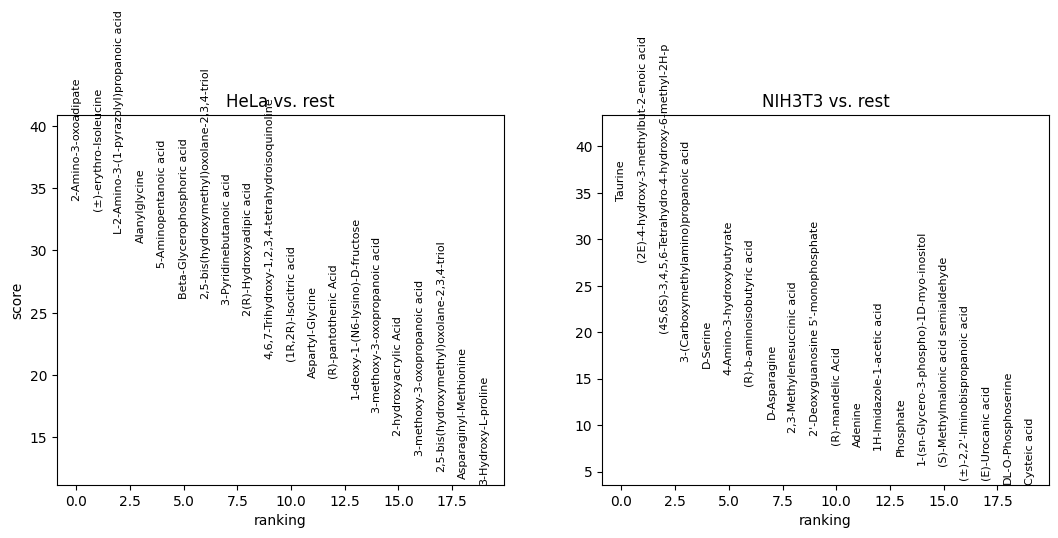

In [27]:
sc.tl.rank_genes_groups(cells_adata, groupby=CONDITION_COL, method="wilcoxon")

# Since ion names are not very expressive, label the plot with the first molecule candidate.
# (The ion is not necessarily this candidate molecule.)
cells_adata.var["first_molecule_name"] = cells_adata.var["moleculeNames"].map(
    lambda names_json: next(iter(json.loads(names_json)), "")[:50]
)
sc.pl.rank_genes_groups(cells_adata, sharey=False, gene_symbols="first_molecule_name")

Visualize the highest-ranking ion for each group:

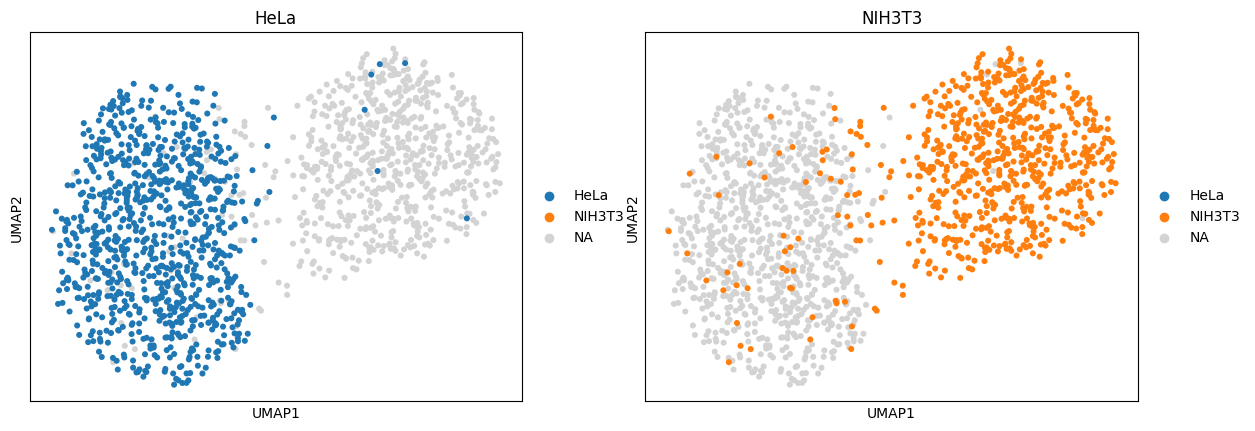

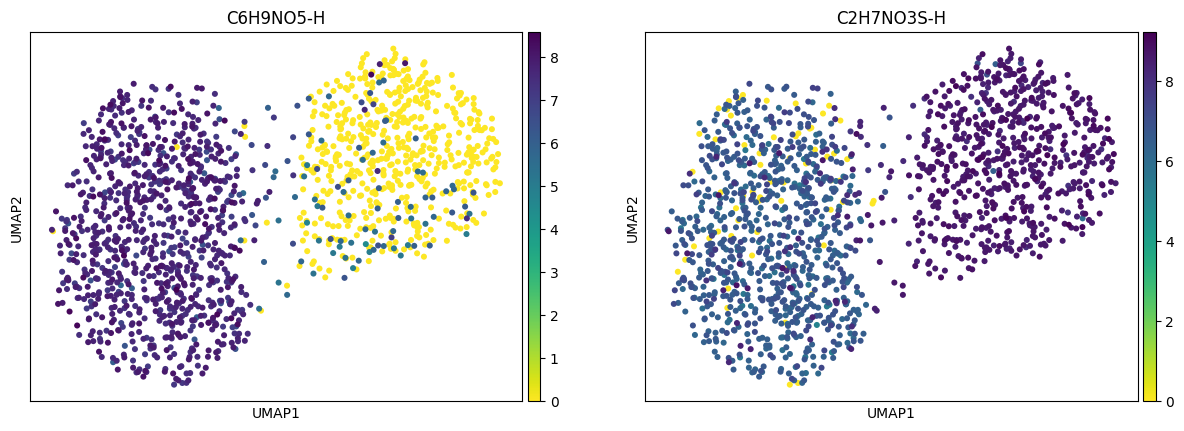

In [28]:
groups = cells_adata.uns["rank_genes_groups"]["names"].dtype.names
best_ion_per_group = cells_adata.uns["rank_genes_groups"]["names"][0]
# Extend obs for plotting single conditions
for group in groups:
    cells_adata.obs[group] = pd.Categorical(
        [group if c == group else np.nan for c in cells_adata.obs[CONDITION_COL].values], categories=groups
    )
sc.pl.umap(cells_adata, color=groups)
sc.pl.umap(cells_adata, color=best_ion_per_group, cmap="viridis_r")